In [1]:
import pandas as pd

# Load the tables from CSV files
ordinary_games_adj = pd.read_csv("data/ordinary_games_adj.csv")
top_aggregated_games_adj = pd.read_csv("data/top_aggregated_games_adj.csv")


In [2]:
# Display the first 5 rows of ordinary_games_adj
ordinary_games_adj.head()

,title,total_sales,na_sales,pal_sales,other_sales,console,genre,publisher,developer,release_date
0,Jampack Winter 2000,1.0,0.55,0.38,0.07,PS,Misc,Sony Computer Entertainment,Sony Computer Entertainment America,2000-11-07
1,Excitebike 64,1.0,0.65,0.15,0.20,"N64, iQue",Racing,Nintendo,Left Field Productions,2000-04-30
2,Pro Evolution Soccer 2018,1.0,0.21,0.47,0.32,"PC, PS3, PS4, X360, XOne",Sports,Konami Digital Entertainment,Konami Digital Entertainment,2017-09-12
3,1942,1.0,0.65,0.14,0.21,"GB, NES, Series",Shooter,Capcom,Capcom,1984-12-01
4,Jeremy McGrath Supercross 2000,1.0,0.63,0.33,0.04,"DC, GB, N64, PS",Racing,Acclaim Entertainment,Acclaim Entertainment,1999-09-29


In [3]:
# Display the first 5 rows of top_aggregated_games_adj
top_aggregated_games_adj.head()

,title,total_sales,na_sales,pal_sales,other_sales,console,genre,publisher,developer,release_date
0,Grand Theft Auto V,64.29,26.181855,28.131249,9.976896,"PC, PS3, PS4, PS5, X360, XOne, XS",Action,Rockstar Games,Rockstar North,2013-09-17
1,Call of Duty: Black Ops,30.99,17.869111,9.567315,3.553574,"DS, PC, PS3, PSN, Wii, X360, XBL",Shooter,Activision,Treyarch,2010-11-09
2,Call of Duty: Modern Warfare 3,30.71,15.770274,11.404835,3.534891,"PC, PS3, Wii, X360",Shooter,Activision,Infinity Ward,2011-11-08
3,Call of Duty: Black Ops II,29.59,14.211252,11.151605,4.227143,"PC, PS3, WiiU, X360",Shooter,Activision,Treyarch,2012-11-13
4,Call of Duty: Ghosts,28.80,15.234563,9.711275,3.854162,"PC, PS3, PS4, WiiU, X360, XOne",Shooter,Activision,Infinity Ward,2013-11-05


In [4]:
missing_values = ordinary_games_adj.isna().sum()

# Display only columns of ordinary_games_adj that have missing values
missing_columns = missing_values[missing_values > 0]
missing_columns

console          199
developer         14
release_date    2910
dtype: int64

In [5]:
missing_values = top_aggregated_games_adj.isna().sum()

# Display only columns of top_aggregated_games_adj that have missing values
missing_columns = missing_values[missing_values > 0]
missing_columns

release_date    1
dtype: int64

# Data Quality Assessment for Prediction

**Overview:**  
In the `ordinary_games_adj` DataFrame, missing values have been identified in the following columns:
- **console:** 199 missing entries
- **developer:** 14 missing entries
- **release_date:** 2910 missing entries

**Impact on Prediction:**  
- The majority of missing data is in the **release_date** column, which is not critical for our prediction task.
- We plan to exclude the **release_date** column when building our prediction model.
- The remaining columns have minimal missing values, providing a reliable and clean dataset for model development.

**Conclusion:**  
The dataset, after removing the **release_date** column, is well-suited for proceeding with predictive analysis. The minimal missing data in the other columns ensures that the dataset is robust enough for accurate forecasting and further processing steps.

In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Function to reduce categories for high-cardinality columns by replacing rare categories with "Other"
def reduce_categories(series, min_count_ratio=0.01):
    total = len(series)
    min_count = total * min_count_ratio
    value_counts = series.value_counts()
    return series.apply(lambda x: x if value_counts[x] >= min_count else "Other")

# Function to prepare features from the raw dataset
def prepare_features(df, target_var):
    # Drop 'release_date' if present and drop any rows with missing values
    df_clean = df.drop(columns=['release_date'], errors='ignore').dropna(axis=0)
    
    # Define which categorical columns to process (if they exist)
    categorical_cols = ['publisher', 'console', 'genre']
    for col in categorical_cols:
        if col in df_clean.columns:
            df_clean[col] = reduce_categories(df_clean[col], min_count_ratio=0.01)
    
    # Create one-hot encoding for the categorical columns
    publisher_dummies = pd.get_dummies(df_clean['publisher'], prefix='publisher', drop_first=True) if 'publisher' in df_clean.columns else pd.DataFrame()
    console_dummies = pd.get_dummies(df_clean['console'], prefix='console', drop_first=True) if 'console' in df_clean.columns else pd.DataFrame()
    genre_dummies   = pd.get_dummies(df_clean['genre'], prefix='genre', drop_first=True)     if 'genre' in df_clean.columns   else pd.DataFrame()
    
    # Select the numeric features that are essential – we assume these are the sales components
    if set(['na_sales','pal_sales','other_sales']).issubset(df_clean.columns):
        numeric_features = df_clean[['na_sales','pal_sales','other_sales']]
    else:
        numeric_features = pd.DataFrame()
    
    # Concatenate numeric and dummy variables into the final feature set
    X_final = pd.concat([numeric_features, publisher_dummies, console_dummies, genre_dummies], axis=1)
    y = df_clean[target_var]
    return X_final, y

# Function to evaluate a given dataset using the specified model
def evaluate_dataset(df, target_var, model):
    X, y = prepare_features(df, target_var)
    train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=42)
    model.fit(train_X, train_y)
    preds = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds)
    rmse = np.sqrt(mean_squared_error(val_y, preds))
    r2 = r2_score(val_y, preds)
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}


# Define target variable
target_variable = 'total_sales'

# Initialize the Random Forest model (you can choose any model you prefer)
model = RandomForestRegressor(random_state=42)

# Evaluate the model on the two datasets
results_ordinary = evaluate_dataset(ordinary_games_adj, target_variable, model)
results_top = evaluate_dataset(top_aggregated_games_adj, target_variable, model)

# Combine the results into a DataFrame for comparison
results = pd.DataFrame({'Ordinary Games': results_ordinary, 'Top Aggregated Games': results_top})
print(results)

# Also print the final feature set for each dataset
X_reduced_ord, _ = prepare_features(ordinary_games_adj, target_variable)
print("\nFinal feature set for Ordinary Games:")
print(X_reduced_ord.columns.tolist())

X_reduced_top, _ = prepare_features(top_aggregated_games_adj, target_variable)
print("\nFinal feature set for Top Aggregated Games:")
print(X_reduced_top.columns.tolist())


      Ordinary Games  Top Aggregated Games
MAE         0.001272              0.126056
RMSE        0.007104              0.307248
R2          0.998395              0.984382

Final feature set for Ordinary Games:
['na_sales', 'pal_sales', 'other_sales', 'publisher_Atari', 'publisher_Bandai', 'publisher_Capcom', 'publisher_Electronic Arts', 'publisher_Konami', 'publisher_Microsoft', 'publisher_Namco Bandai', 'publisher_Nintendo', 'publisher_Other', 'publisher_Sega', 'publisher_Sony Computer Entertainment', 'publisher_THQ', 'publisher_Ubisoft', 'publisher_Unknown', 'console_And', 'console_DC', 'console_DS', 'console_DSiW', 'console_GB', 'console_GBA', 'console_NES', 'console_NS', 'console_Other', 'console_PC', 'console_PS', 'console_PS2', 'console_PSN', 'console_PSP', 'console_PSV', 'console_SNES', 'console_Wii', 'console_XBL', 'genre_Action-Adventure', 'genre_Adventure', 'genre_Fighting', 'genre_Misc', 'genre_Other', 'genre_Platform', 'genre_Puzzle', 'genre_Racing', 'genre_Role-Playing', 

# What to Do Next with the Model

## Improve the Model
I already achieved strong results using a Random Forest model, but it can be further improved by tuning its hyperparameters (e.g., with GridSearchCV or RandomizedSearchCV).

This will help the model make more stable and accurate predictions on new data.

### 📊 Why Are These Results Considered Good?
#### MAE (Mean Absolute Error)
- **Ordinary Games**: `0.00127` → error of ~1,270 copies
- **Top Aggregated Games**: `0.12606` → error of ~126,000 copies

#### RMSE (Root Mean Squared Error)
- **Ordinary Games**: `0.00710` → error of ~7,100 copies
- **Top Aggregated Games**: `0.30725` → error of ~307,000 copies

#### R² (Coefficient of Determination)
- **Ordinary Games**: `0.9984` → model explains 99.84% of sales variance
- **Top Aggregated Games**: `0.9844` → model explains 98.44% of sales variance

For a regression task, these are excellent results — especially for ordinary games. The model has very low error and highly reliable predictions.

## Analyze Feature Importance
Using SHAP, I will identify which features have the strongest influence on predictions.

This helps interpret how the model "thinks" and what differentiates ordinary from top aggregated games.


In [7]:
from sklearn.ensemble import RandomForestRegressor

# Prepare features and target variable
X_ord, y_ord = prepare_features(ordinary_games_adj, 'total_sales')
train_X, val_X, train_y, val_y = train_test_split(X_ord, y_ord, random_state=42)

# Initialize and train the Random Forest model
best_rf_ord = RandomForestRegressor(random_state=42)
best_rf_ord.fit(train_X, train_y)


RandomForestRegressor(random_state=42)

c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


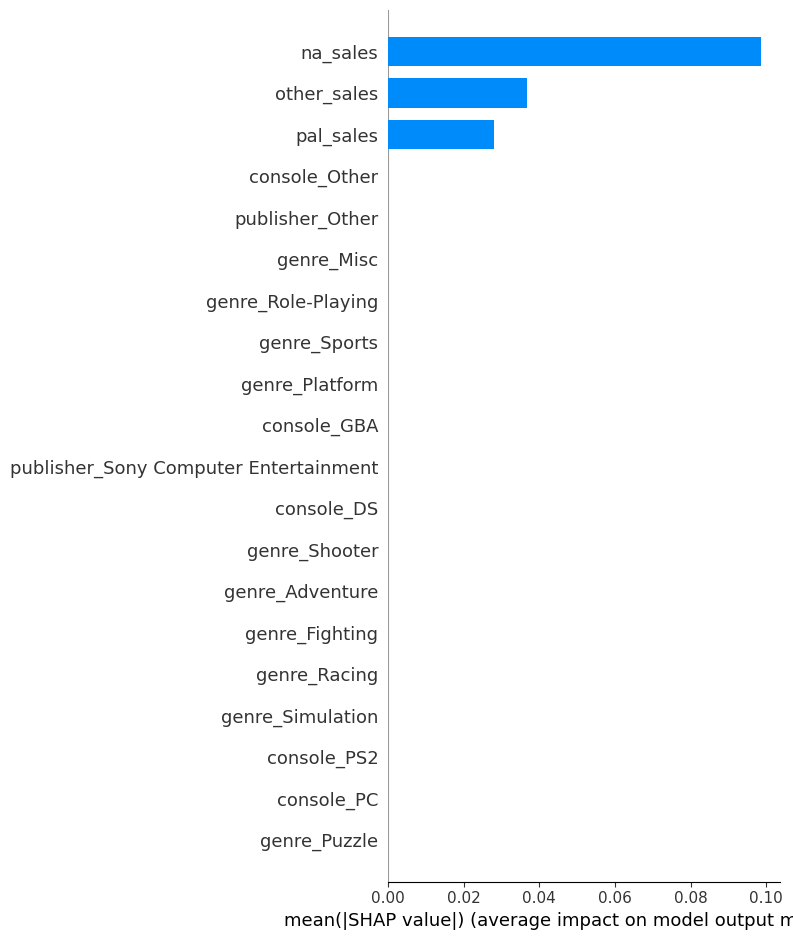

In [8]:
import shap

# Limit the number of rows for SHAP analysis
sampled_X = train_X.sample(n=1000, random_state=42)

# Create SHAP explainer and compute SHAP values on the sample
explainer = shap.TreeExplainer(best_rf_ord)
shap_values = explainer.shap_values(sampled_X)

# Plot SHAP summary
shap.summary_plot(shap_values, sampled_X, plot_type="bar")


## Analyzing Feature Importance Without Sales Components

To better understand the impact of categorical features like **genre**, **console**, and **publisher**, I will now retrain the model **excluding the three regional sales components**: `na_sales`, `pal_sales`, and `other_sales`.

This will help determine how much these non-sales features alone contribute to predicting `total_sales`, and which of them are most influential without the direct influence of numeric sales inputs.

This step allows for deeper insight into which types of games, platforms, and publishers tend to drive higher overall sales regardless of the explicit regional breakdowns.

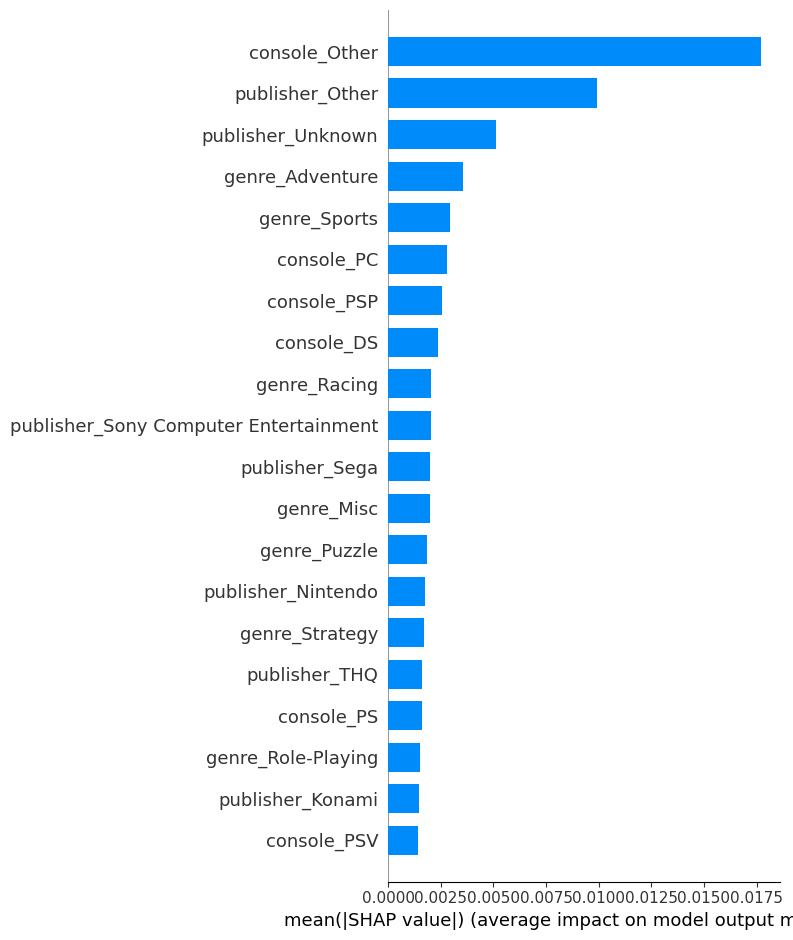

In [9]:
# Remove regional sales features
X_ord, y_ord = prepare_features(ordinary_games_adj, 'total_sales')
X_dropped = X_ord.drop(columns=['na_sales', 'pal_sales', 'other_sales'], errors='ignore')

# Split data and train model
train_X_dropped, val_X_dropped, train_y_dropped, val_y_dropped = train_test_split(X_dropped, y_ord, random_state=42)
best_rf_no_sales = RandomForestRegressor(random_state=42)
best_rf_no_sales.fit(train_X_dropped, train_y_dropped)

# Limit the number of rows for SHAP analysis to improve performance
sampled_X = train_X_dropped.sample(n=1000, random_state=42)

# Compute SHAP values on the sampled data
explainer = shap.TreeExplainer(best_rf_no_sales, feature_perturbation="tree_path_dependent", model_output="raw")
shap_values = explainer.shap_values(sampled_X)

# Plot SHAP summary
shap.summary_plot(shap_values, sampled_X, plot_type="bar")

## Preliminary Conclusion on SHAP Analysis Without Sales Features

After removing the direct sales-related features (`na_sales`, `pal_sales`, and `other_sales`), the SHAP analysis shows that the remaining categorical features (like `genre`, `console`, and `publisher`) have relatively **low individual impact** on the model's output.

The most impactful features in this setup are `console_Other`, `publisher_Other`, and `publisher_Unknown`, followed by a few genre and console categories. However, even the top features have **significantly lower SHAP values** compared to the SHAP summary from the full model.

### Interpretation:
- This suggests that the model relies heavily on the regional sales components for accurate predictions.
- When those are removed, the predictive power of genre, platform, and publisher becomes much weaker.
- Therefore, **categorical attributes alone are not strong indicators of total sales**, at least not in this dataset.

This reinforces the idea that while categorical features might provide context, **the actual sales numbers are the strongest signals** when predicting total game sales.

In [10]:
# Predict and evaluate model with sales features
val_preds_with_sales = best_rf_ord.predict(val_X)
mae_with_sales = mean_absolute_error(val_y, val_preds_with_sales)
rmse_with_sales = np.sqrt(mean_squared_error(val_y, val_preds_with_sales))
r2_with_sales = r2_score(val_y, val_preds_with_sales)

# Predict and evaluate model without sales features
val_preds_no_sales = best_rf_no_sales.predict(val_X_dropped)
mae_no_sales = mean_absolute_error(val_y_dropped, val_preds_no_sales)
rmse_no_sales = np.sqrt(mean_squared_error(val_y_dropped, val_preds_no_sales))
r2_no_sales = r2_score(val_y_dropped, val_preds_no_sales)

# Print comparison
print("Model with sales features:")
print(f"MAE: {mae_with_sales:.4f}, RMSE: {rmse_with_sales:.4f}, R²: {r2_with_sales:.4f}")
print("\nModel without sales features:")
print(f"MAE: {mae_no_sales:.4f}, RMSE: {rmse_no_sales:.4f}, R²: {r2_no_sales:.4f}")


Model with sales features:
MAE: 0.0013, RMSE: 0.0071, R²: 0.9984

Model without sales features:
MAE: 0.1425, RMSE: 0.1771, R²: 0.0018


## Comparing Model Performance: With vs Without Regional Sales Features

To assess how important the regional sales components (`na_sales`, `pal_sales`, `other_sales`) are for predicting `total_sales`, I trained two separate Random Forest models:

- One **with** the regional sales features included (baseline model)
- One **without** those features (to test only genre, console, and publisher)

### Evaluation Results

**Model with sales features:**  
- MAE: **0.0013**  
- RMSE: **0.0071**  
- R²: **0.9984**  

**Model without sales features:**  
- MAE: **0.1425**  
- RMSE: **0.1771**  
- R²: **0.0018**  

### Interpretation

These results clearly show that the regional sales features are extremely important for accurate prediction. Removing them causes a drastic drop in model performance, especially in the R² score, which goes from near-perfect to almost zero.

This confirms that most of the predictive power in the original model came from those three regional sales components. Genre, console, and publisher by themselves provide very limited ability to predict total sales.

## Reflection on Dataset and Predictive Limitations

While experimenting with different feature sets, it became evident that the dataset in its current form has significant limitations for predictive modeling:

### Key Insight
- The **regional sales figures** (`na_sales`, `pal_sales`, `other_sales`) are **essentially what define** the target variable `total_sales`.
- When these features are removed, model performance drops dramatically. This means that genre, console, and publisher offer **very little predictive value on their own**.

### Implications
- The dataset is suitable for **descriptive analysis** — exploring trends across platforms, publishers, and genres.
- But it performs poorly for **predictive modeling without sales data** — we can't predict future success based on metadata alone (like genre or platform).

## ✅ Next Steps

The final model clearly showed that regional sales figures (`na_sales`, `pal_sales`, `other_sales`) are the strongest predictors of total sales — removing them drastically reduced prediction accuracy.

If the goal is to predict a game’s future success **before release**, we need more meaningful and diverse data (e.g., marketing budgets, pre-orders, franchise popularity). The current dataset is mostly descriptive, not predictive.

The only step left:  
➡️ Create final visualizations in `video_game_sales_visuals_2024.ipynb` to present the analysis visually and summarize all insights.

After that — project complete 🎉